# Import de bibliotecas

In [2]:
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

# Import de dados

In [3]:
ko_df = pd.read_csv("KO Historical Data.csv")
fb_df = pd.read_csv("FB Historical Data.csv")

# Transformação de dados em serie temporal

In [4]:
ko_df["Date Format"] = pd.to_datetime(ko_df["Date"])
ts_ko = ko_df[["Date Format","Price"]].sort_values(by="Date Format").reset_index(drop=True)
fb_df["Date Format"] = pd.to_datetime(fb_df["Date"])
ts_fb = fb_df[["Date Format","Price"]].sort_values(by="Date Format").reset_index(drop=True)

ts_ko_train = ts_ko[ts_ko["Date Format"] <  datetime.datetime(2020, 5, 1)]
ts_ko_test  = ts_ko[ts_ko["Date Format"] >= datetime.datetime(2020, 5, 1)]
ts_fb_train = ts_fb[ts_fb["Date Format"] <  datetime.datetime(2020, 5, 1)]
ts_fb_test  = ts_fb[ts_fb["Date Format"] >= datetime.datetime(2020, 5, 1)]


# Apresentação serie temporal Coca-Cola - Treino

<AxesSubplot:title={'center':'Serie Temporal Coca-Cola - Dataset Treino'}, ylabel='Price'>

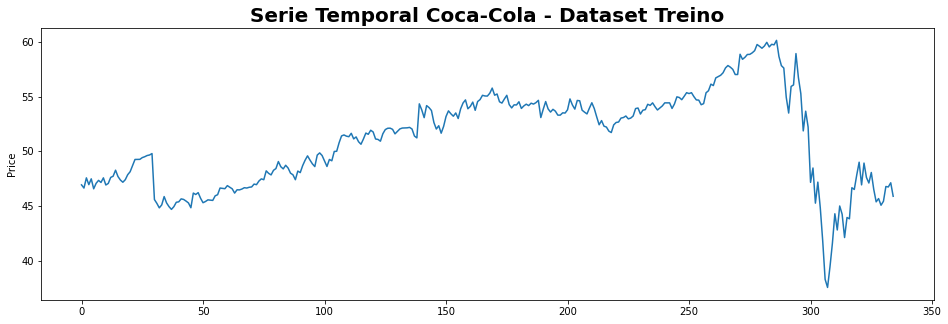

In [5]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.set_title("Serie Temporal Coca-Cola - Dataset Treino", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
sns.lineplot(x=ts_ko_train.index,y=ts_ko_train["Price"])


# Apresentação serie temporal Coca-Cola - Test

<AxesSubplot:title={'center':'Serie Temporal Coca-Cola - Dataset Teste'}, ylabel='Price'>

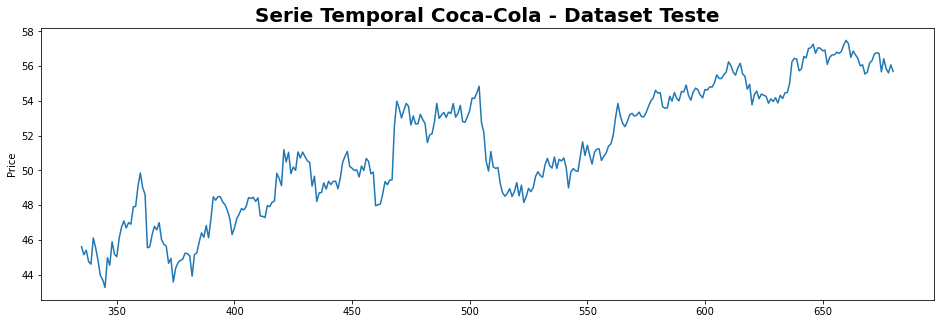

In [6]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.set_title("Serie Temporal Coca-Cola - Dataset Teste", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
sns.lineplot(x=ts_ko_test.index,y=ts_ko_test["Price"])

# Apresentação serie temporal Facebook - Treino

<AxesSubplot:title={'center':'Serie Temporal Facebook - Dataset Treino'}, ylabel='Price'>

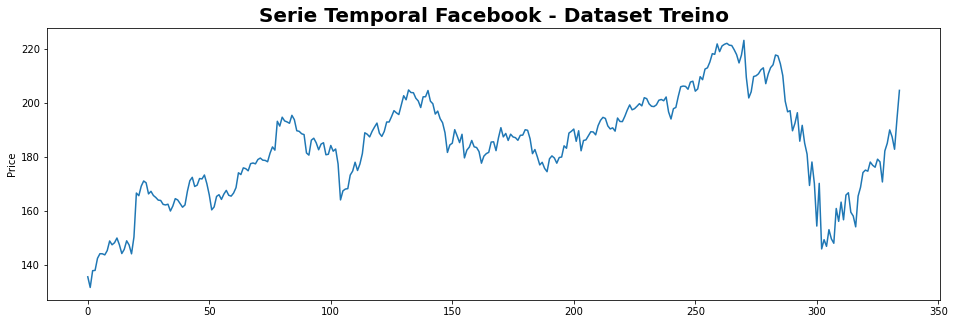

In [7]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.set_title("Serie Temporal Facebook - Dataset Treino", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
sns.lineplot(x=ts_fb_train.index,y=ts_fb_train["Price"])

# Apresentação serie temporal Facebook - Teste

<AxesSubplot:title={'center':'Serie Temporal Facebook - Dataset Teste'}, ylabel='Price'>

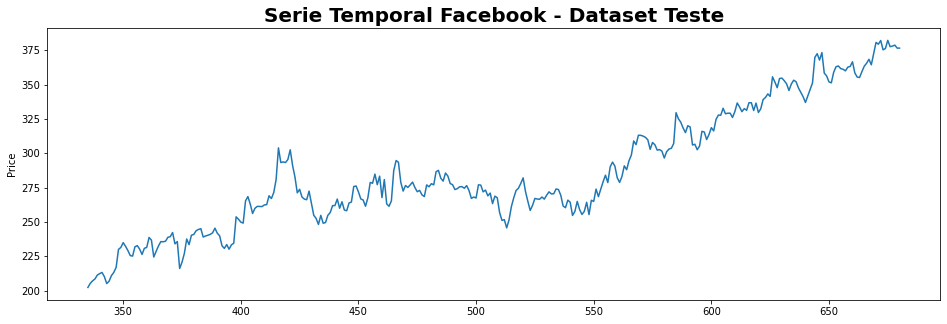

In [8]:
fig,ax = plt.subplots(1,figsize=(16,5))
ax.set_title("Serie Temporal Facebook - Dataset Teste", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
sns.lineplot(x=ts_fb_test.index,y=ts_fb_test["Price"])

# Padronização de variaveis

In [9]:
ts_ko_train.columns = ["ds","y"]
ts_ko_test.columns = ["ds","y"]
ts_fb_train.columns = ["ds","y"]
ts_fb_test.columns = ["ds","y"]

ts_ko_test = ts_ko_test.reset_index(drop=True)
ts_fb_test = ts_fb_test.reset_index(drop=True)

# Funções de Suporte

In [10]:
# Função de criação de Regreção Linear
class LR_Estimator(BaseEstimator):
    #Função retorna MSE da previsão
    def score(self,y_true,y_pred):
        self.mse = mean_squared_error(y_true,y_pred)
        return self.mse
    #Função que faz o calculo da regressão linear
    def fit(self,X,y):
        self.k = len(X.columns)
        self.Xb = np.c_[np.ones((X.shape[0],1)),X] #adding x0 = 1
        self.theta_ = np.linalg.inv(self.Xb.T.dot(self.Xb)).dot(self.Xb.T).dot(y)
    
    #Função que predição
    def predict(self,X_test):
        self.X_new = np.c_[np.ones((len(X_test),1)),X_test]
        y_predict = self.X_new.dot(self.theta_)
        return y_predict
    #Função de criação de matrix de variaveis
    def createMatrix(self,data,k):
        self.matriz = []
        self.y = []
        for self.m in range(0,len(data)):
            if len(data[self.m:self.m+k]) >= k:
                try :
                    self.y.append(data[self.m+k])
                    self.matriz.append(data[self.m:self.m+k].values)
                except:
                    pass
        self.mt = pd.DataFrame(self.matriz,index=range(k,len(self.matriz)+k)).reset_index(drop=True)
        return self.mt,self.y
#
def returnA_B(a,Ex,Ey,ExQuad,Exy):
    aa = a/a
    ab = Ex/a
    ac = Ey/a
    p1 = Ex-aa*Ex
    p2 = ExQuad-ab*Ex
    p3 = Exy-ac*Ex
    pa = p2/p2
    pb = p3/p2
    A = pb/pa
    B = ac-ab*A
    return round(A, 5),round(B, 5)

#Função que retorna o RMSE da predições
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#Função de execução de quadrados minimos
def least_square(X,k):
    ind_prev_arr = []
    y_prev_arr = []
    for l in range(len(X)-k):
        Xk = X[l:l+k]
        xq = Xk.apply(lambda x : x**2)
        ExQuad = 0
        Exy = 0
        for ind in Xk.index:
            ExQuad = ExQuad + (ind**2)
            Exy = (ind * Xk[ind]) + Exy
        Ex = sum(Xk.index)
        Ey = sum(Xk.values)
        AA,BB = returnA_B(len(Xk),Ex,Ey,ExQuad,Exy)
        ind_prev = k+l
        y_prev = (ind_prev*AA) + BB
        ind_prev_arr.append(ind_prev)
        y_prev_arr.append(y_prev)
    resp = pd.Series(y_prev_arr,index=ind_prev_arr)
    fim = rmse(resp, X[k:1000])
    return resp
  
#Função de Criação de matrix PHI
def CreateMatrix(data,k):
    matriz = []
    y = []
    for m in range(0,len(data)):
        if len(data[m:m+k]) >= k:
            try :
                y.append(data[m+k])
                matriz.append(data[m:m+k].values)
            except:
                pass

    mt = pd.DataFrame(matriz,index=range(k,len(matriz)+k)).reset_index(drop=True)
    return mt,y
#Função encontrar erro medio para cada nivel de delay
def findDelay(df):
    list_mse = []
    l_r = []
    for k in range(1,56):
        error = []
        lr = LR_Estimator()
        X,y = lr.createMatrix(df["y"],k)

        step = int(len(X)/5)
        X_1 = X[:step]
        X_2 = X[step:step*2]
        X_3 = X[step*2:step*3]
        X_4 = X[step*3:step*4]
        X_5 = X[step*4:step*5]

        y_1 = y[:step]
        y_2 = y[step:step*2]
        y_3 = y[step*2:step*3]
        y_4 = y[step*3:step*4]
        y_5 = y[step*4:step*5]

        X_1_train = pd.concat([X_2,X_3,X_4,X_5]).reset_index(drop=True)
        y_1_train = y_2+y_3+y_4+y_5
        X_1_valid = X_1
        y_1_valid = y_1
        lr.fit(X_1_valid,y_1_valid)
        y_chapeu_X_1 = lr.predict(X_1_valid)
        error.append(lr.score(y_1_valid,y_chapeu_X_1))

        X_2_train = pd.concat([X_1,X_3,X_4,X_5]).reset_index(drop=True)
        y_2_train = y_1+y_3+y_4+y_5
        X_2_valid = X_2
        y_2_valid = y_2
        lr.fit(X_2_valid,y_2_valid)
        y_chapeu_X_2 = lr.predict(X_2_valid)
        error.append(lr.score(y_2_valid,y_chapeu_X_2))

        X_3_train = pd.concat([X_1,X_2,X_4,X_5]).reset_index(drop=True)
        y_3_train = y_1+y_2+y_4+y_5
        X_3_valid = X_3
        y_3_valid = y_3
        lr.fit(X_3_valid,y_3_valid)
        y_chapeu_X_3 = lr.predict(X_3_valid)
        error.append(lr.score(y_3_valid,y_chapeu_X_3))

        X_4_train = pd.concat([X_1,X_2,X_3,X_5]).reset_index(drop=True)
        y_4_train = y_1+y_2+y_3+y_5
        X_4_valid = X_4
        y_4_valid = y_4
        lr.fit(X_4_valid,y_4_valid)
        y_chapeu_X_4 = lr.predict(X_4_valid)
        error.append(lr.score(y_4_valid,y_chapeu_X_4))

        X_5_train = pd.concat([X_1,X_2,X_3,X_4]).reset_index(drop=True)
        y_5_train = y_1+y_2+y_3+y_4
        X_5_valid = X_5
        y_5_valid = y_5
        lr.fit(X_5_valid,y_5_valid)
        y_chapeu_X_5 = lr.predict(X_5_valid)
        error.append(lr.score(y_5_valid,y_chapeu_X_5))
        list_mse.append(sum(error) / len(error))
    mse = pd.Series(list_mse,index=range(1,len(list_mse)+1))
    return mse


# Comparação de delay dados do Facebook

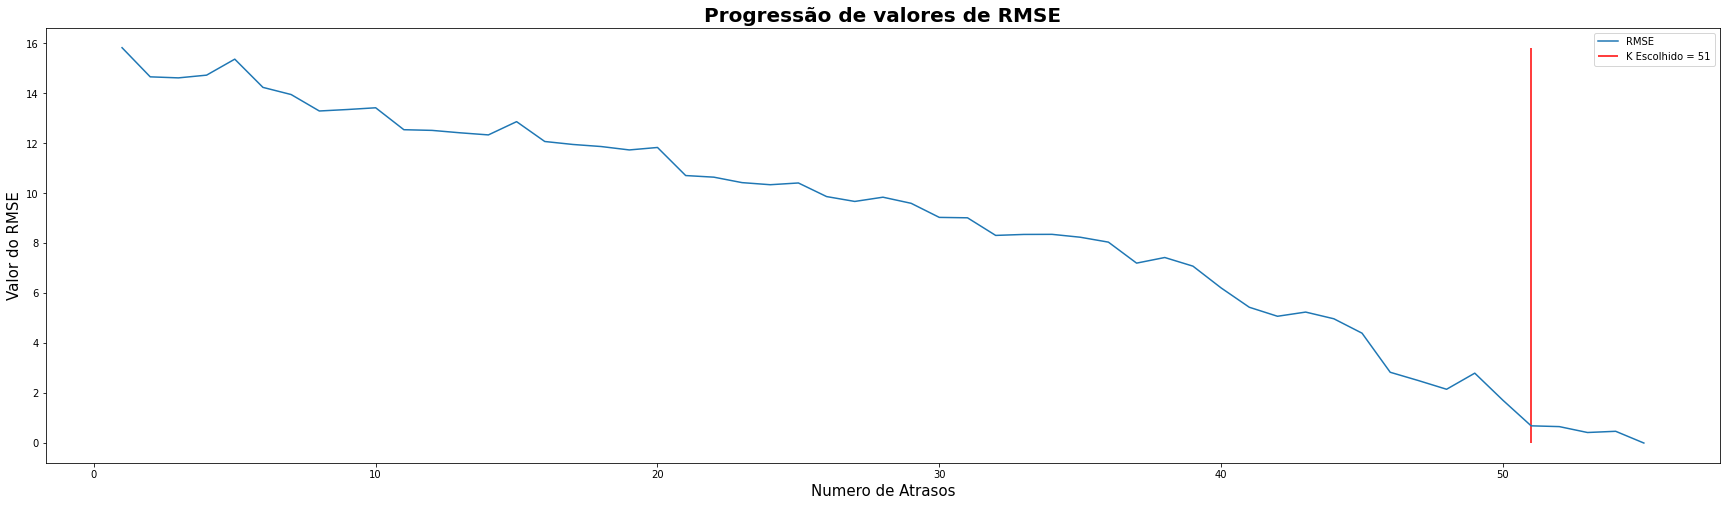

In [11]:
    fig,ax = plt.subplots(figsize=(30,8))
    sns.lineplot(x=findDelay(ts_fb_train).index,y=findDelay(ts_fb_train),label="RMSE")
    ax.set_title("Progressão de valores de RMSE", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_ylabel('Valor do RMSE', fontsize = 15)
    ax.set_xlabel('Numero de Atrasos', fontsize = 15)
    plt.vlines(51,findDelay(ts_fb_train).min(),findDelay(ts_fb_train).max(),colors='r',label="K Escolhido = 51")
    plt.legend()

# Comparação de delay dados do Coca-cola

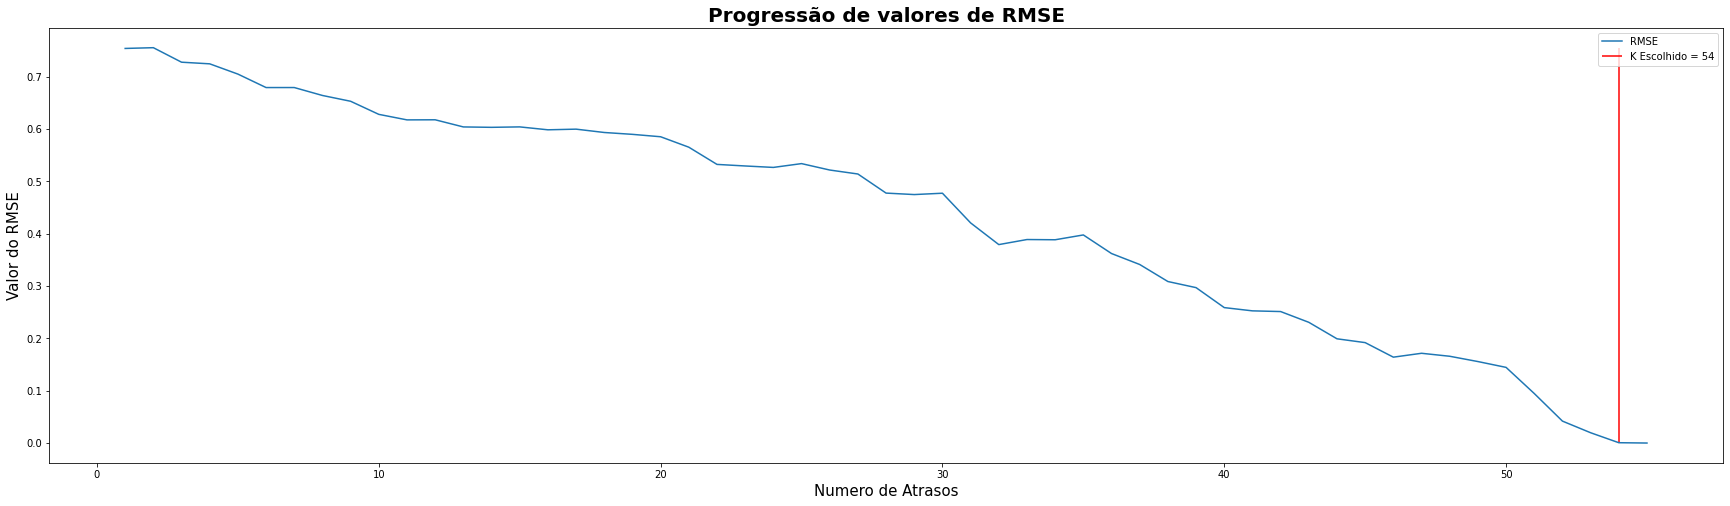

In [12]:
    fig,ax = plt.subplots(figsize=(30,8))
    sns.lineplot(x=findDelay(ts_ko_train).index,y=findDelay(ts_ko_train),label="RMSE")
    ax.set_title("Progressão de valores de RMSE", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_ylabel('Valor do RMSE', fontsize = 15)
    ax.set_xlabel('Numero de Atrasos', fontsize = 15)
    plt.vlines(54,findDelay(ts_ko_train).min(),findDelay(ts_ko_train).max(),colors='r',label="K Escolhido = 54")
    plt.legend()

# Execução de modelo com dados Facebook

In [13]:
lr_fb = LR_Estimator()
X_fb,y_fb = lr_fb.createMatrix(ts_fb_train["y"],51)
lr_fb.fit(X_fb,y_fb)
X_1_fb,y_1_fb = lr_fb.createMatrix(ts_fb_test["y"].reset_index(drop=True),51)
y_prev_fb = lr_fb.predict(X_1_fb)
erro_rmse = lr_fb.score(y_1_fb,y_prev_fb)
y_1_fb = pd.Series(y_1_fb)
y_prev_fb = pd.Series(y_prev_fb)

# Comparação ações facebook valor ral e previsto

Text(0.5, 0, 'Periodo')

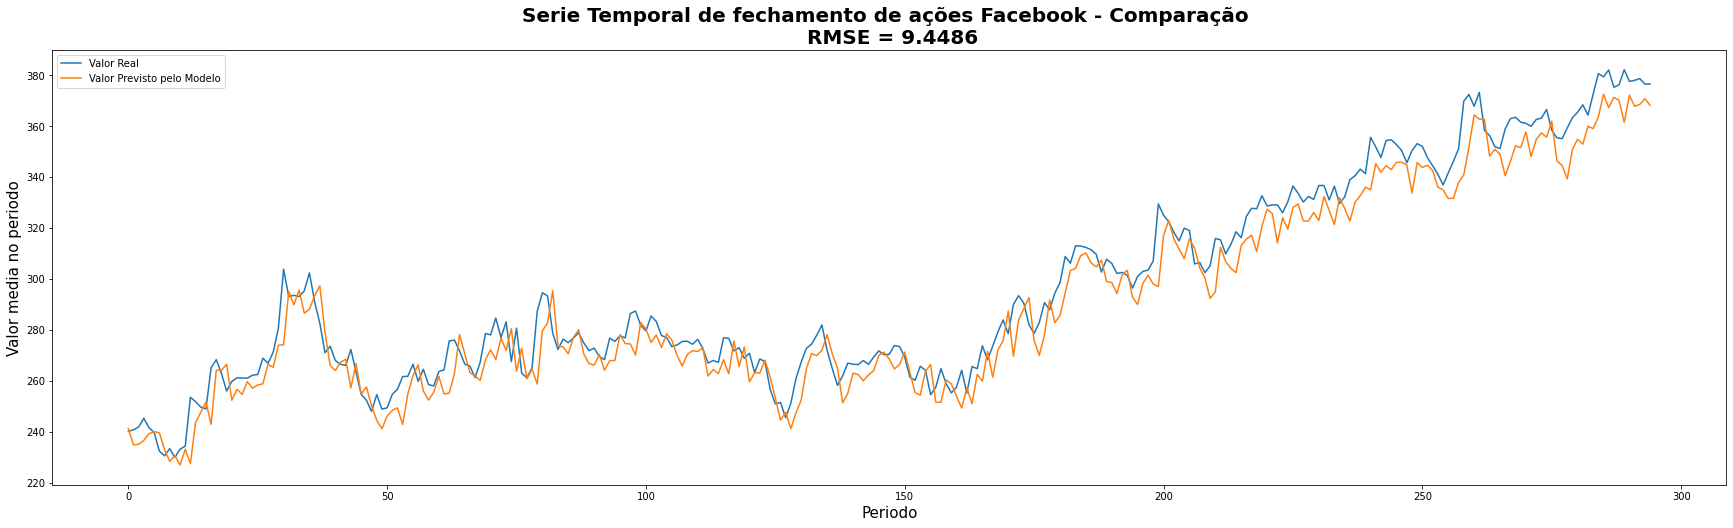

In [14]:
fig,ax = plt.subplots(figsize=(30,8))
sns.lineplot(x=y_1_fb.index,y=y_1_fb,label="Valor Real")
sns.lineplot(x=y_prev_fb.index,y=y_prev_fb,label="Valor Previsto pelo Modelo")
ax.set_title("Serie Temporal de fechamento de ações Facebook - Comparação \n RMSE = {:.4f}".format(
    rmse(y_prev_fb,y_1_fb)), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_ylabel('Valor media no periodo', fontsize = 15)
ax.set_xlabel('Periodo', fontsize = 15)

# Execução de modelo com dados Coca Cola

In [15]:
lr_ko = LR_Estimator()
X_ko,y_ko = lr_ko.createMatrix(ts_ko_train["y"],54)
lr_ko.fit(X_ko,y_ko)
X_1_ko,y_1_ko = lr_ko.createMatrix(ts_ko_test["y"].reset_index(drop=True),54)
y_prev_ko = lr_ko.predict(X_1_ko)
erro_rmse_ko = lr_ko.score(y_1_ko,y_prev_ko)
y_1_ko = pd.Series(y_1_ko)
y_prev_ko = pd.Series(y_prev_ko)

# Comparação ações Coca Cola valor ral e previsto

Text(0.5, 0, 'Periodo')

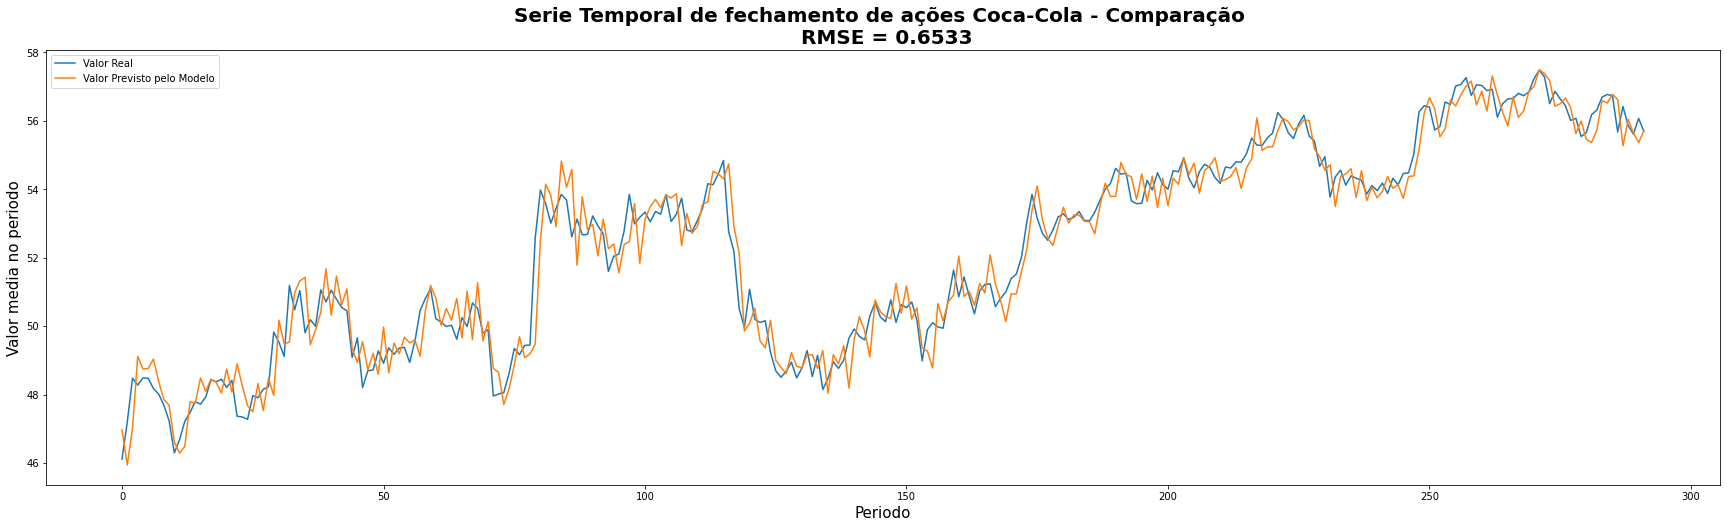

In [16]:
fig,ax = plt.subplots(figsize=(30,8))
sns.lineplot(x=y_1_ko.index,y=y_1_ko,label="Valor Real")
sns.lineplot(x=y_prev_ko.index,y=y_prev_ko,label="Valor Previsto pelo Modelo")
ax.set_title("Serie Temporal de fechamento de ações Coca-Cola - Comparação \n RMSE = {:.4f}".format(rmse(y_prev_ko,y_1_ko)), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_ylabel('Valor media no periodo', fontsize = 15)
ax.set_xlabel('Periodo', fontsize = 15)